In [48]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [49]:
data = pd.read_csv("data.csv")

In [50]:
data.head()

,Unnamed: 0,temp,humidity
0,0,23.91,42.80
1,1,25.91,42.08
2,2,25.76,44.75
3,3,25.15,45.84
4,4,26.10,41.12


In [51]:
data_set = data.values[:,1:3]

In [52]:
data_set.shape

(10000, 2)

In [53]:
data_set

array([[23.91, 42.8 ],
       [25.91, 42.08],
       [25.76, 44.75],
       ...,
       [10.83, 30.86],
       [10.7 , 32.14],
       [11.44, 34.02]])

In [54]:
humidity_temp = torch.empty([data_set.shape[0],3,2,1])

In [55]:
humidity_temp.shape

torch.Size([10000, 3, 2, 1])

In [56]:
humidity_label = torch.empty([len(data_set[:,0]),1,1])
humidity_label.shape

torch.Size([10000, 1, 1])

In [57]:
humidity_temp[:,0,0,0] = torch.tensor(data_set[:,0])
humidity_temp[:,0,1,0] = torch.tensor(data_set[:,1])
humidity_temp[0:-1,1,0,0] = torch.tensor(data_set[1:,0])
humidity_temp[0:-1,1,1,0] = torch.tensor(data_set[1:,1])
humidity_temp[0:-2,2,0,0] = torch.tensor(data_set[2:,0])
humidity_temp[0:-2,2,1,0] = torch.tensor(data_set[2:,1])

humidity_label = torch.tensor(data_set[:,1])

In [58]:
print(humidity_temp.shape)
print(humidity_label.shape)

torch.Size([10000, 3, 2, 1])
torch.Size([10000])


In [59]:
humidity_x = humidity_temp[0:-3,:,:]
humidity_y = humidity_label[3:]
print(humidity_x[0:2,:,:])
print(humidity_y[0:2])

tensor([[[[23.9100],
          [42.8000]],

         [[25.9100],
          [42.0800]],

         [[25.7600],
          [44.7500]]],


        [[[25.9100],
          [42.0800]],

         [[25.7600],
          [44.7500]],

         [[25.1500],
          [45.8400]]]])
tensor([45.8400, 41.1200], dtype=torch.float64)


In [60]:
humidity_x_train, humidity_x_test, humidity_y_train, humidity_y_test = train_test_split(humidity_x, humidity_y,  
                                                                        test_size = 0.1, shuffle = False)

In [61]:
print(humidity_x_train.shape)
print(humidity_y_train.shape)
print(humidity_x_test.shape)
print(humidity_y_test.shape)

torch.Size([8997, 3, 2, 1])
torch.Size([8997])
torch.Size([1000, 3, 2, 1])
torch.Size([1000])


In [62]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, (2,1))  # 3 input channels, 32 output channels, 1x2 kernel
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = x.view(x.size()[0], -1)# flatten the output of the convolutional layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

In [63]:
# 定义训练函数
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).double()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 定义测试函数
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
    test_loss /= len(test_loader.dataset)
    return test_loss

In [64]:
if __name__ == '__main__':
    
    x_train = humidity_x_train
    y_train = humidity_y_train
    train_data = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    
    x_test = humidity_x_test
    y_test = humidity_y_test
    test_data = TensorDataset(x_test, y_test)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    
    epochs = 50
    best_loss = 10000
    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, criterion)
        test_loss = test(model, device, test_loader, criterion)

        print('Epoch {}, Test Loss: {:.4f}'.format(epoch+1, test_loss))
        if best_loss > test_loss:
            best_loss = test_loss
            torch.save(model,"CNN.pt")
            print("best model saved")



/Users/jiaxingzhang/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jiaxingzhang/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/jiaxingzhang/env/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same 

Epoch 1, Test Loss: 0.5770
best model saved
Epoch 2, Test Loss: 0.6158
Epoch 3, Test Loss: 0.6115
Epoch 4, Test Loss: 38.9662
Epoch 5, Test Loss: 0.3487
best model saved
Epoch 6, Test Loss: 7.0407
Epoch 7, Test Loss: 0.8893
Epoch 8, Test Loss: 0.7007
Epoch 9, Test Loss: 0.5777
Epoch 10, Test Loss: 8.9561
Epoch 11, Test Loss: 1.9885
Epoch 12, Test Loss: 1.6261
Epoch 13, Test Loss: 1.5128
Epoch 14, Test Loss: 1.4259
Epoch 15, Test Loss: 1.3494
Epoch 16, Test Loss: 1.2853
Epoch 17, Test Loss: 1.2864
Epoch 18, Test Loss: 1.2576
Epoch 19, Test Loss: 1.2137
Epoch 20, Test Loss: 1.1686
Epoch 21, Test Loss: 1.1233
Epoch 22, Test Loss: 1.0351
Epoch 23, Test Loss: 1.0314
Epoch 24, Test Loss: 1.7084
Epoch 25, Test Loss: 0.8875
Epoch 26, Test Loss: 0.9227
Epoch 27, Test Loss: 0.9136
Epoch 28, Test Loss: 0.9011
Epoch 29, Test Loss: 0.8944
Epoch 30, Test Loss: 0.8792
Epoch 31, Test Loss: 0.8904
Epoch 32, Test Loss: 0.8557
Epoch 33, Test Loss: 0.8409
Epoch 34, Test Loss: 0.8221
Epoch 35, Test Loss: 0

In [65]:
test = humidity_x_test[0:100,:,:,:]
test.shape

torch.Size([100, 3, 2, 1])

In [66]:
predictor = torch.load("CNN.pt")

In [67]:
result = np.zeros([100])
result = predictor(test).detach().numpy()

In [68]:
type(result)

numpy.ndarray

<class 'numpy.ndarray'>


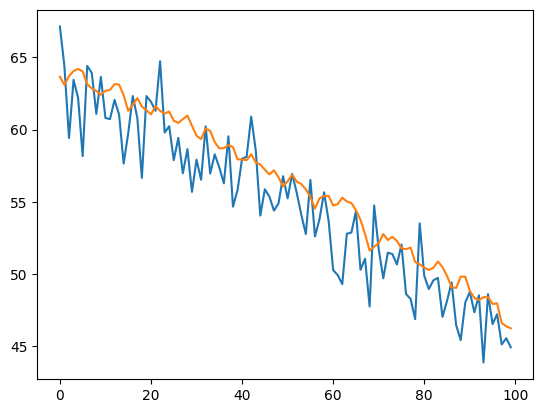

In [69]:
x = np.arange(0,100)
print(type(x))
plt.plot(x,humidity_y_test[0:100])
plt.plot(x,result)

In [70]:
difference = humidity_y_test[0:100] - result[:,0]
print(difference)

tensor([ 3.4810,  1.2682, -4.2934, -0.6097, -2.0070, -5.8677,  1.2745,  1.0862,
        -1.5932,  1.2376, -1.8844, -2.0254, -1.0961, -2.0858, -4.7303, -1.5500,
         0.6036, -1.3675, -4.9441,  0.9769,  0.8703, -0.3203,  3.4381, -1.3149,
        -1.0193, -2.7341, -1.0415, -3.7500, -2.3273, -4.5835, -1.6602, -2.8179,
         0.1573, -2.9552, -0.8420, -1.3214, -2.4413,  0.6143, -4.1241, -2.1375,
         0.0520,  0.2313,  2.5992,  0.8358, -3.5354, -1.3548, -1.5402, -2.7969,
        -1.8029,  0.7184, -1.1846,  0.0608, -0.7844, -2.1239, -3.0910,  1.1795,
        -1.9301, -1.4462,  0.2562, -1.7301, -4.4728, -4.9228, -5.9894, -2.2402,
        -2.0431, -0.0744, -3.4609, -1.7069, -3.8729,  2.8609, -0.4224, -3.0704,
        -0.8762, -1.1941, -1.6350,  0.2696, -3.1149, -3.5540, -3.9591,  2.8370,
        -0.5683, -1.3159, -0.8711, -1.1390, -3.4456, -1.7316,  0.3368, -2.5744,
        -4.4041, -1.7947, -0.0824, -0.9889,  0.3267, -4.5261,  0.2028, -1.3991,
        -0.7524, -1.4868, -0.8273, -1.31